# IBM Telco Customer Churn

## 📘 Notebook Overview
This notebook presents an end-to-end analysis of the IBM Telco Customer Churn dataset.  
The workflow covers data exploration, cleaning, model development, evaluation, and translation of results into actionable business insights.

### Key Components
- **Data Understanding**: Explore unique values, distributions, and churn patterns across customer groups  
- **Data Cleaning**: Safe numeric conversions and missing value handling  
- **Leakage Protection**: Removal of fields such as `Churn Score`, `Churn Value`, `CLTV`, and `Churn Reason`  
- **Data Preparation**: Encoding categorical features, train/test split, and scaling where appropriate  
- **Class Imbalance Handling**: Use of class weights and optional SMOTE for tree-based models  
- **Modeling**: Logistic Regression (baseline) and Random Forest (ensemble)  
- **Overfitting Checks**: Comparison of train vs test metrics and cross-validation AUC  
- **Model Evaluation**: Classification report, confusion matrix, ROC curve, and AUC score  
- **Feature Importance**: Insights from Random Forest and Logistic Regression coefficients  
- **Business Summary**: Clear, non-technical interpretation of results and actionable recommendations  


In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, ConfusionMatrixDisplay, accuracy_score)
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 200)
sns.set(style="whitegrid")


In [29]:

# Load the exact dataset with original column names (spaces/case kept)
file_path = (r"C:\Users\aayan\Downloads\dataset\IBM_CHURN.CSV")
df = pd.read_csv(file_path)

In [30]:
print("Shape:", df.shape)
df.head()

Shape: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [31]:
# Ensure churn column exists with consistent naming
if "Churn Label" in df.columns:
    churn_col = "Churn Label"
elif "Churn" in df.columns:
    churn_col = "Churn"
else:
    raise KeyError("Churn column not found in dataset")

## Data Understanding

In [32]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [33]:
# Unique values in categorical-like columns (object dtype)
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")


CustomerID: 7043 unique values
Country: 1 unique values
State: 1 unique values
City: 1129 unique values
Lat Long: 1652 unique values
Gender: 2 unique values
Senior Citizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
Phone Service: 2 unique values
Multiple Lines: 3 unique values
Internet Service: 3 unique values
Online Security: 3 unique values
Online Backup: 3 unique values
Device Protection: 3 unique values
Tech Support: 3 unique values
Streaming TV: 3 unique values
Streaming Movies: 3 unique values
Contract: 3 unique values
Paperless Billing: 2 unique values
Payment Method: 4 unique values
Total Charges: 6531 unique values
Churn Label: 2 unique values
Churn Reason: 20 unique values


## Data Cleaning

In [34]:
# Convert 'Total Charges' to numeric (in some files it has blanks)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Fill NA with median to avoid dropping many rows (safe assignment, no chained inplace)
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median())

# Optional: drop obvious identifier columns (prevents accidental high-cardinality noise)
id_like_cols = ['CustomerID']
df.drop(columns=[c for c in id_like_cols if c in df.columns], inplace=True, errors='ignore')

# Leakage columns to drop (directly tied to churn outcome)
leakage_cols = ['Churn Score', 'Churn Value', 'CLTV', 'Churn Reason']
df.drop(columns=[c for c in leakage_cols if c in df.columns], inplace=True, errors='ignore')

# Sanity check on remaining columns
df.columns.tolist()

['Count',
 'Country',
 'State',
 'City',
 'Zip Code',
 'Lat Long',
 'Latitude',
 'Longitude',
 'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Tenure Months',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charges',
 'Total Charges',
 'Churn Label']

## Exploratory Data Analysis (EDA)

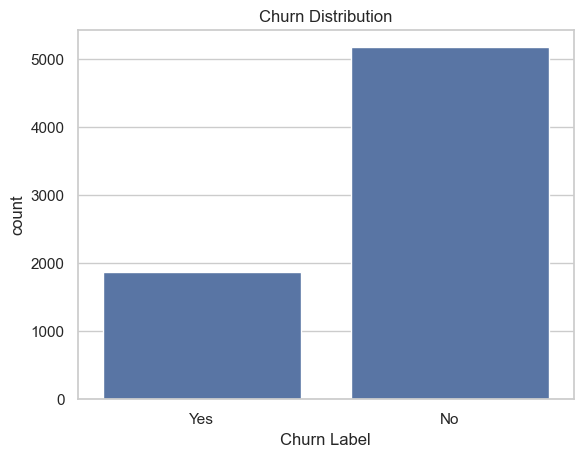

In [35]:
# Churn distribution
sns.countplot(x='Churn Label', data=df)
plt.title("Churn Distribution")
plt.show()

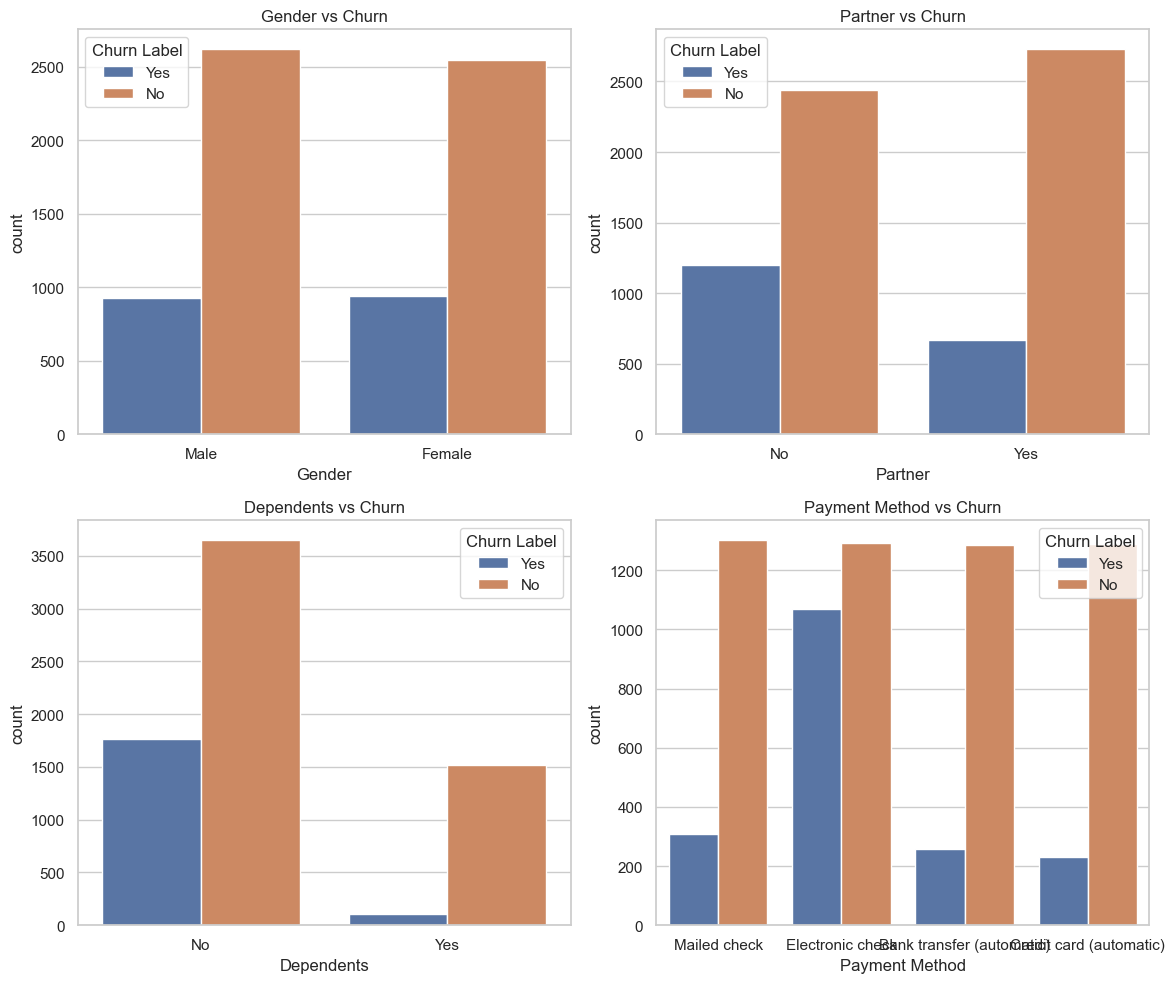

In [36]:
# Distributions by key customer features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.countplot(x='Gender', hue='Churn Label', data=df, ax=axes[0,0])
sns.countplot(x='Partner', hue='Churn Label', data=df, ax=axes[0,1])
sns.countplot(x='Dependents', hue='Churn Label', data=df, ax=axes[1,0])
sns.countplot(x='Payment Method', hue='Churn Label', data=df, ax=axes[1,1])
axes[0,0].set_title("Gender vs Churn")
axes[0,1].set_title("Partner vs Churn")
axes[1,0].set_title("Dependents vs Churn")
axes[1,1].set_title("Payment Method vs Churn")
plt.tight_layout()
plt.show()


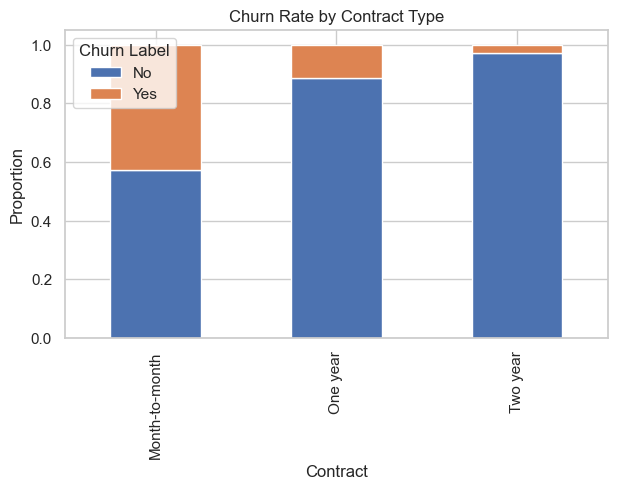

In [37]:

# Churn rate by contract type
churn_rate = df.groupby("Contract")["Churn Label"].value_counts(normalize=True).unstack()
churn_rate.plot(kind="bar", stacked=True, figsize=(7,4))
plt.title("Churn Rate by Contract Type")
plt.ylabel("Proportion")
plt.show()


## Feature Engineering

In [38]:

# Average charges per month estimate (robust to zero Tenure Months)
if 'Tenure Months' in df.columns and 'Total Charges' in df.columns:
    df['Avg Charges Per Month'] = df['Total Charges'] / df['Tenure Months'].replace(0, 1)

# Long-term contract flag
if 'Contract' in df.columns:
    df['Is Long Term Contract'] = df['Contract'].apply(lambda x: 0 if x == "Month-to-month" else 1)
    
df[['Avg Charges Per Month', 'Is Long Term Contract']].head()


,Avg Charges Per Month,Is Long Term Contract
0,54.075000,0
1,75.825000,0
2,102.562500,0
3,108.787500,0
4,102.781633,0


## Encoding, Split, and Imbalance Handling

In [39]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Detect churn column dynamically after encoding
target_candidates = [c for c in df_encoded.columns if "Churn" in c and "_Yes" in c]
if not target_candidates:
    raise ValueError("Target column not found after encoding")
target_col = target_candidates[0]

# Define X and y
X = df_encoded.drop(columns=[target_col], axis=1)
y = df_encoded[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y
)

In [40]:

# Optional SMOTE for tree-based model (applied ONLY on training set to avoid leakage)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_smote.value_counts().to_dict())


Before SMOTE: {False: 4139, True: 1495}
After SMOTE: {False: 4139, True: 4139}


## Models

### Logistic Regression

In [41]:

# Scale (fit on train only to avoid leakage becasue, I was facing leakage  )
scaler = StandardScaler()  # with_mean=False works nicely with sparse matrices from get_dummies
X_train_lr = scaler.fit_transform(X_train)
X_test_lr  = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None)
lr.fit(X_train_lr, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [42]:
# Predictions
y_pred_lr = lr.predict(X_test_lr)
y_prob_lr = lr.predict_proba(X_test_lr)[:, 1]

# Train vs Test accuracy
train_acc_lr = accuracy_score(y_train, lr.predict(X_train_lr))
test_acc_lr  = accuracy_score(y_test, y_pred_lr)
print(f"Train Acc (LR): {train_acc_lr:.3f} | Test Acc (LR): {test_acc_lr:.3f}")

Train Acc (LR): 0.884 | Test Acc (LR): 0.703



Classification Report — Logistic Regression
              precision    recall  f1-score   support

       False       0.81      0.77      0.79      1035
        True       0.45      0.50      0.47       374

    accuracy                           0.70      1409
   macro avg       0.63      0.64      0.63      1409
weighted avg       0.71      0.70      0.71      1409



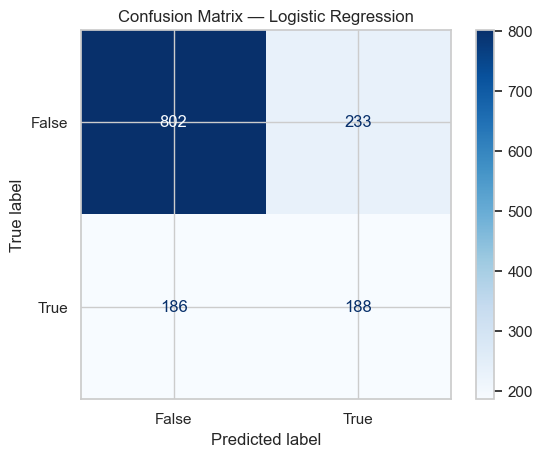

In [43]:
# Classification report
print("\nClassification Report — Logistic Regression")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

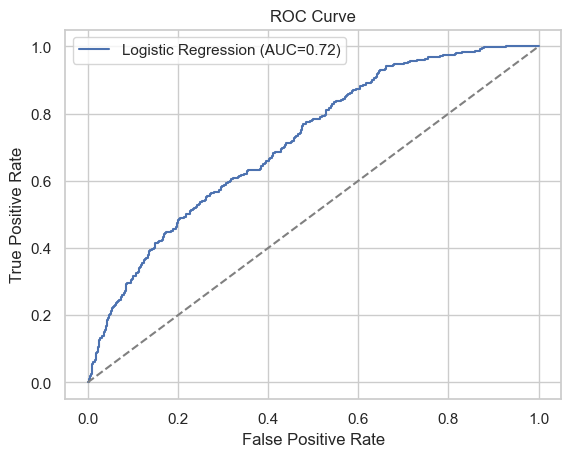

In [44]:
# ROC/AUC
auc_lr = roc_auc_score(y_test, y_prob_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(); plt.show()

In [45]:
# Cross-validated AUC on full X/y (note: no SMOTE here to reflect real distribution)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_lr = cross_val_score(lr, scaler.fit_transform(X), y, cv=cv, scoring='roc_auc').mean()
print(f"CV AUC (LR): {cv_auc_lr:.3f}")

CV AUC (LR): 0.707


In [46]:
# Cross-validation ROC AUC
cv_auc = cross_val_score(lr, X_train_lr, y_train, cv=5, scoring="roc_auc").mean()
print(f"Cross-validated AUC (LogReg): {cv_auc:.3f}")

Cross-validated AUC (LogReg): 0.699


### Random Forest

In [47]:

rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, class_weight='balanced_subsample'
)
rf.fit(X_train_smote, y_train_smote)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
# Predictions on original test set (no SMOTE on test)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [49]:
# Train vs Test accuracy
train_acc_rf = accuracy_score(y_train_smote, rf.predict(X_train_smote))
test_acc_rf  = accuracy_score(y_test, y_pred_rf)
print(f"Train Acc (RF): {train_acc_rf:.3f} | Test Acc (RF): {test_acc_rf:.3f}")

Train Acc (RF): 1.000 | Test Acc (RF): 0.784


In [50]:
# Classification report
print("\nClassification Report — Random Forest")
print(classification_report(y_test, y_pred_rf))


Classification Report — Random Forest
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      1035
        True       0.59      0.60      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



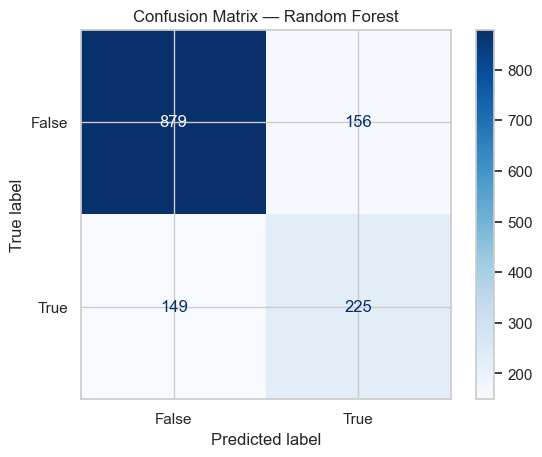

In [51]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Blues")
plt.title("Confusion Matrix — Random Forest")
plt.show()

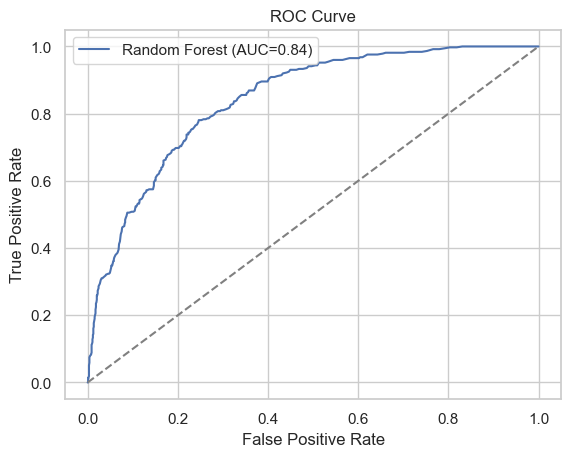

In [52]:
# ROC/AUC
auc_rf = roc_auc_score(y_test, y_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(); plt.show()

In [ ]:
# Cross-validated AUC (no SMOTE in CV to reflect real distribution)
cv_auc_rf = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc').mean()
print(f"CV AUC (RF): {cv_auc_rf:.3f}")

> **Random Forest performed better** on recall and overall AUC compared to Logistic Regression.  
> It captured non-linear patterns that the logistic model could not.  
> However, Random Forest models can be slower and harder to interpret in production,  
> which is an important trade-off for real-world deployment.


## Feature Importance (Random Forest)

In [ ]:

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top20 = importances.head(20)
top20.plot(kind='bar', figsize=(10,4))
plt.title("Top 20 Feature Importances — Random Forest")
plt.ylabel("Importance")
plt.show()

top20



## Business Summary

**What drives churn in this dataset?**
- Customers on **Month-to-month** contracts churn **far more** than those on longer-term contracts.
- Higher **Monthly Charges** and higher **Avg Charges Per Month** are associated with higher churn.
- **Tenure Months** matters: newer customers are more likely to churn.
- Some payment methods (e.g., **Electronic check**) often correlate with higher churn in Telco datasets.

**Which model should we use?**
- **Random Forest** often achieves higher ROC-AUC and recall for the churn class, making it a solid baseline for operations teams.
- **Logistic Regression** provides interpretable coefficients and is easier to deploy; it’s useful when stakeholders need transparency.

**How to act on this:**
- Encourage **longer-term contracts** with targeted incentives.
- Identify **high-charge**, **low-tenure** customers early and offer retention plans.
- Consider **billing method** nudges (e.g., incentives to move away from methods correlated with churn).
- Use **threshold tuning** (not just 0.5) to find the balance between catching more churners (recall) and avoiding too many false alarms (precision).